## Wurst Tutorial

#### Github repository: [https://github.com/polca/wurst](https://github.com/polca/wurst)
#### Documentation: [https://wurst.readthedocs.io/](https://wurst.readthedocs.io/)
#### Wurst authors: Chris Mutel, Brian Cox
#### Tutorial author: Romain Sacchi
#### Duration: 1.5 hours

### Scenario: Prospective Assessment of Future Solar PV Technologies

#### Background:
The European energy agency is keen on understanding the potential future of solar PV technology. 
With advances in research, there are predictions of enhanced module efficiency, changes in supply chains, 
and extended lifetimes for PV modules in the next decade.

#### Objective:
To modify the ecoinvent data to reflect these anticipated changes and evaluate the prospective environmental 
benefits or potential concerns of these future solar PV technologies.

### 1. Introduction:

`wurst` is a Python library tailored for performing operations Life Cycle Assessment (LCA) data, especially the [ecoinvent](https://ecoinvent.org/) database. It provides tools to search, filter, modify, and link LCA datasets. It is a core library of [`premise`](https://github.com/polca/premise), and certainly a core library of the [POLCA](https://github.com/polca/) tool kit.

### Data Exploration:

1. Load the ecoinvent database.
2. Extract all processes related to European solar PV.

### 2. Installation:

In [1]:
import wurst
import bw2io, bw2data

In [ ]:
if "premise_ei391" in bw2data.projects:
    bw2data.projects.delete_project("premise_ei391")
    print("Delted project")

In [ ]:
bw2io.restore_project_directory("/srv/data/ecoinvent-3.9.1-cutoff.tar.gz", project_name="premise_ei391")

#### 2.1 activate a project with ecoinvent

In [2]:
bw2data.projects.set_current("premise_ei391")

#### 2.2 list databases

In [ ]:
bw2data.databases

### 3. Extracting Data:

In [ ]:
database = wurst.extract_brightway2_databases("ecoinvent-3.9.1-cutoff")

Import additional inventories

#### 3.1 Pickle database
Doing so allows us to load directly the database without going through extraction again.

In [ ]:
import pickle

with open(r"ei391.pickle", "wb") as output_file:
    pickle.dump(database, output_file)

#### 3.2 Load database
Create a function that will unpickle our database, to avoid extracting it from the brightway project.

In [3]:
import pickle

def load_db():
    with open(r"ei391.pickle", "rb") as input_file:
        db = pickle.load(input_file)

    for ds in db:
        if "categories" in ds:
            del ds["categories"]
            
    return db

In [ ]:
db = load_db()

In [ ]:
len(db)

In [ ]:
database == db

In [ ]:
# let's create three databases for 2020, 2035 and 2050
#db_2020 = load_db()
db_2035 = load_db()
db_2050 = load_db()

In [ ]:
# and we delete database and db
del database
del db

### 4. Searching for Processes:

Let's search for European solar panels in ecoinvent.

In [ ]:
import wurst.searching as ws

In [ ]:
solar_pv = ws.get_many(db_2020, 
    ws.contains("name", "photovoltaic")
)

for ds in solar_pv:
    print(ds["name"])

Let's remove markets

In [ ]:
solar_pv = ws.get_many(db_2020, 
    ws.contains("name", "photovoltaic"),
    ws.exclude(
        ws.contains("name", "market for"),
    )
)

for ds in solar_pv:
    print(ds["name"])

Let's also remove electricity producing datasets

In [ ]:
pv_filter = [
    ws.contains("name", "photovoltaic"),
    ws.either(
        ws.contains("name", "installation"),
        ws.contains("name", "construction"),
    ),
    ws.exclude(ws.contains("name", "market for"),),
    ws.exclude(ws.contains("name", "electricity")),
    ws.exclude(ws.contains("name", "factory")),
    ws.exclude(ws.contains("name", "module")),
    ws.equals("unit", "unit"),
]
solar_pv = ws.get_many(
    db_2020, 
    *pv_filter
)

for ds in solar_pv:
    print(ds["name"], ds["location"])

### 5. Filtering Data:
List only European datasets

In [ ]:
from constructive_geometries import geomatcher

In [ ]:
geo = geomatcher.Geomatcher()

In [ ]:
european_countries = geo.contained("RER")

In [ ]:
pv_filter.append(
    ws.either(*[
        ws.equals("location", loc) for loc in european_countries
    ])
)

for ds in ws.get_many(
    db_2020,
    *pv_filter
):
    print(ds["name"], ds["location"])

### Modify Module Efficiency:

Increase the efficiency of solar PV modules by a certain amount based on future predictions.
We can do so by reducing the area of panels needed per kilowatt-peak installation.

Here are some efficiency projections we can use:
							
| Synthesis           |           |      |          |           |          |      |      |      |
|---------------------|-----------|------|----------|-----------|----------|------|------|------|
| % module efficiency | ribbon-Si | a-Si | micro-Si | single-Si | multi-Si | CIGS | CIS  | CdTe |
| 2005                |           |      |          |           |          |      |      |      |
| 2010                | 9         | 9.5  | 10       | 15.1      | 14       | 11   | 11   | 10   |
| 2020                | 12        | 12.5 | 11.9     | 17.9      | 16.8     | 14   | 14   | 16.8 |
| 2050                | 13.5      | 14.2 | 12.5     | 26.7      | 24.4     | 23.4 | 23.4 | 21   |4	21


In [ ]:
import xarray as xr
# let's store this as a dict
# Creating the dictionary from the provided data

efficiency_data = {
    "ribbon-Si": {
        2010: 9,
        2020: 12,
        2050: 13.5
    },
    "a-Si": {
        2010: 9.5,
        2020: 12.5,
        2050: 14.2
    },
    "micro-Si": {
        2010: 10,
        2020: 11.9,
        2050: 12.5
    },
    "single-Si": {
        2010: 15.1,
        2020: 17.9,
        2050: 26.7
    },
    "multi-Si": {
        2010: 14,
        2020: 16.8,
        2050: 24.4
    },
    "CIGS": {
        2010: 11,
        2020: 14,
        2050: 23.4
    },
    "CIS": {
        2010: 11,
        2020: 14,
        2050: 23.4
    },
    "CdTe": {
        2010: 10,
        2020: 16.8,
        2050: 21
    }
}

# Adjusting the structure of the dictionary to fit into a DataArray
data_values = []
technologies = list(efficiency_data.keys())
years = sorted(list(efficiency_data[technologies[0]].keys()))

for technology in technologies:
    data_values.append([efficiency_data[technology][year] for year in years])

# Creating the xarray DataArray
efficiency_da = xr.DataArray(
    data_values,
    coords=[technologies, years],
    dims=["technology", "year"]
)


In [ ]:
efficiency_da.interp(year=2020)

### 6. Transforming Datasets:

#### Module efficiency
We want to look into the solar PV installation datasets and:
1. Identify the installation power
2. Identify the current efficiency
3. Identifiy the technology
4. Fetch the new efficiency
5. Modify the inputs accodingly

In [ ]:
import re
import numpy as np
from prettytable import PrettyTable

def fetch_pv_power(name):
    # we use regular expression to extract the power from the dataset name (in kW)
    power = float(re.findall(r"[-+]?\d*\.\d+|\d+", name)[0])
    
    # if in MW, convert to kW
    if "mwp" in name.lower():
        power *= 1000

    return power

def modify_module_efficiency(db, year):

    modifications = []
    
    for dataset in ws.get_many(
        db,
        *pv_filter
    ):
    
        power = fetch_pv_power(dataset["name"])
    
        # we look for an input of PV panel, in square meters
        for exc in ws.technosphere(
            dataset,
            *[
                ws.either(
                    ws.contains("name", "photovoltaic panel"),
                    ws.contains("name", "photovoltaic laminate"),
                ),
                ws.equals("unit", "square meter"),
            ],
        ):
            surface = float(exc["amount"])
            max_power = surface  # in kW, since we assume a constant 1,000W/m^2
            current_eff = power / max_power
    
            possible_techs = [
                "ribbon-Si",
                "a-Si",
                "micro-Si",
                "single-Si",
                "multi-Si",
                "CIGS",
                "CIS",
                "CdTe",
            ]
            pv_tech = [
                i for i in possible_techs if i.lower() in exc["name"].lower()
            ]
    
            if len(pv_tech) > 0:
                pv_tech = pv_tech[0]
    
                new_eff = efficiency_da.sel(technology=pv_tech).interp(year=year).values/100
    
                # in case self.year <2010 or >2050
                new_eff = np.clip(new_eff, 0.1, 0.27)
                
                modifications.append(
                    [dataset["name"][-60:], power, pv_tech, round(current_eff, 2), round(new_eff, 2), round(float(current_eff / new_eff), 2)]
                )
                exc["amount"] *= float(current_eff / new_eff)
    
    table = PrettyTable(["Name", "Power", "Tech", "Current eff", "New eff", "Scaling factor"])
    table.add_rows(modifications)
    print(table)

    return db

### Extend Module Lifetime:

Increase the operational lifetime of the solar PV modules from the typical 25 years to, say, 30 years in 2035 and 40 years in 2050.
This modification will affect the input requirements per kilowatt hour produced.

In [ ]:
def modify_pv_lifetime(db, current_lifetime, new_lifetime):

    modifications = []
    
    # search where our PV panels are used:
    for ds in ws.get_many(
        db,
        ws.contains("name", "electricity"),
        ws.equals("unit", "kilowatt hour"),
        ws.exclude(ws.contains("name", "renewable"))
    ):
        for exc in ws.technosphere(
            ds,
            *pv_filter
        ):
            power = fetch_pv_power(exc["name"])
    
            panel_fraction = exc["amount"]
            lifetime_production = 1/exc["amount"]
            annual_production = 1/exc["amount"]/current_lifetime
            annual_prod_per_kW = annual_production / power

            exc["amount"] *= current_lifetime/new_lifetime
    
            modifications.append(
                [
                    ds["name"][-60:],
                    ds["location"],
                    int(lifetime_production),
                    int(annual_production),
                    int(annual_prod_per_kW),
                    '{:.2E}'.format(exc["amount"]),
                    '{:.2E}'.format(exc["amount"] * current_lifetime/new_lifetime)
                ]
            )
    
    table = PrettyTable(["Name", "Loc", "kWh/lifetime", "kWh/year", "kWh/year/kW", "Old input", "New input"])
    table.add_rows(modifications)
    print(table)

    return db

### Decarbonize the production of aluminium

PV panel installations require substantial amounts of aliminium for the panel frame itself, but also, and mostly, for the mounting system.

The production of alumiminium in certain regions still relies to a significant extent on fossil-based electricity (see *market for electricity, high voltage, aluminium industry*). The European Environmental Agency foresees that, while natural gas-based electricity will still be used by aluminum smelters, coal will slowly be phased out: by half by 2035, and completely by 2050.

The European Environmental Agency also thinks that natural gas-fired power plants will be 5% and 10% more efficient by 2035 and 2050, relative to today. 

In [ ]:
def modify_al_electricity_mix(db, scaling_factor_coal, scaling_factor_coal_ng):

    ############### Aluminium electricity mix #################
    modifications = []

    for ds in ws.get_many(
            db,
            ws.contains("name", "market for electricity, high voltage, aluminium industry"),
            ws.equals("unit", "kilowatt hour"),
        ):

        shares, surplus = {}, 0

        for exc in ws.technosphere(
            ds,
            ws.contains("name", "electricity production"),
            ws.contains("unit", "kilowatt hour")
        ):
            shares[exc["name"]] = {"old": exc["amount"]}

        
        for tech, share in shares.items():
            if "coal" in tech:
                shares[tech]["new"] = share["old"] * scaling_factor_coal
                surplus = share["old"] - share["new"]

        
        for tech, share in shares.items():
            if "coal" not in tech:
                shares[tech]["new"] = share["old"] + (surplus / (len(shares) - 1))
                
        for exc in ws.technosphere(
            ds,
            ws.contains("name", "electricity production")             
        ):
            if exc["name"] in shares:
                exc["amount"] = shares[exc["name"]]["new"]

        modifications.extend(
            [
                ds["name"][-30:], ds["location"], tech[-30:], round(v["old"], 3), round(v["new"], 3), round(sum(x["new"] for x in shares.values()), 2)
            ] for tech, v in shares.items()
        )

    table = PrettyTable(["Name", "Loc", "Tech", "Old share", "New share", "Sum shares"])
    table.add_rows(modifications)
    print(table)

    ################ NG POWER PLANTS #####################

    generation_filters = [
        ws.contains('name', 'electricity production'),
        ws.contains("name", "natural gas"),
        ws.equals('unit', 'kilowatt hour'),
    ]

    fuel_independent_cooling = ws.doesnt_contain_any('name', (
        'water, decarbonised', ))

    fuel_independent = ws.doesnt_contain_any('name', (
        'Methane, fossil', 'Sulfur dioxide', 'Carbon monoxide, fossil',
        'Nitrogen oxides', 'Dinitrogen monoxide', 'Particulates'
    ))

    for ds in ws.get_many(db, *generation_filters):

        wurst.transformations.change_exchanges_by_constant_factor(
            ds,
            scaling_factor_coal_ng,  # Or whatever from input data
            [fuel_independent_cooling],
            [fuel_independent]
        )
    
    return db

### 7. Running the script:

Run the three transformation functions for 2035 and 2050

In [ ]:
db_2035 = modify_module_efficiency(db_2035, 2035)
db_2050 = modify_module_efficiency(db_2050, 2050)

db_2035 = modify_pv_lifetime(db_2035, 25, 30)
db_2050 = modify_pv_lifetime(db_2050, 25, 40)

db_2035 = modify_al_electricity_mix(db_2035, .5, .95)
db_2050 = modify_al_electricity_mix(db_2050, 0, .9)

### 8. Exporting Databases:

In [ ]:
len(db_2035)

In [ ]:
if "PV 2035" in bw2data.databases:
    del bw2data.databases["PV 2035"]

if "PV 2050" in bw2data.databases:
    del bw2data.databases["PV 2050"]

In [ ]:
wurst.write_brightway2_database(db_2035, "PV 2035")
wurst.write_brightway2_database(db_2050, "PV 2050")

### 9. Comparing results:

In [7]:
FU = [
    {act: 1} for db in [
        "ecoinvent 3.9.1 cutoff", "PV 2035", "PV 2050"
    ] for act in bw2data.Database(db) if "electricity production" in act["name"]
    and "photovoltaic" in act["name"] and act["unit"] == "kilowatt hour" 
    and act["location"] == "CH"
]

In [4]:
import bw2calc
import matplotlib.pyplot as plt
bw2data.projects.set_current("ei39")

In [5]:
method = [('IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')]

In [8]:
bw2calc.multi_lca.calculation_setups["PVs"] = {
    "inv": FU,
    "ia": method
}

In [9]:
lca = bw2calc.MultiLCA("PVs")

In [10]:
acts = [list(d.keys())[0] for d in lca.func_units]

In [12]:
import pandas as pd
results = pd.DataFrame(
    zip(
        [a["name"] for a in acts],
        [a["database"] for a in acts],
        lca.results.flatten()
    ),
    columns=["name", "year", "GWP"]
)

In [13]:
results.head()

,name,year,GWP
0,"electricity production, photovoltaic, 3kWp fac...",ecoinvent 3.9.1 cutoff,0.112627
1,"electricity production, photovoltaic, 3kWp fac...",ecoinvent 3.9.1 cutoff,0.137437
2,"electricity production, photovoltaic, 3kWp sla...",ecoinvent 3.9.1 cutoff,0.104598
3,"electricity production, photovoltaic, 3kWp sla...",ecoinvent 3.9.1 cutoff,0.093098
4,"electricity production, photovoltaic, 3kWp sla...",ecoinvent 3.9.1 cutoff,0.080736


In [14]:
results = results.replace("ecoinvent 3.9.1 cutoff", 2020)
results = results.replace("PV 2035", 2035)
results = results.replace("PV 2050", 2050)
results["year"] = results["year"].astype("str")

Text(0, 0.5, 'kg CO$_2$-eq./kWh')

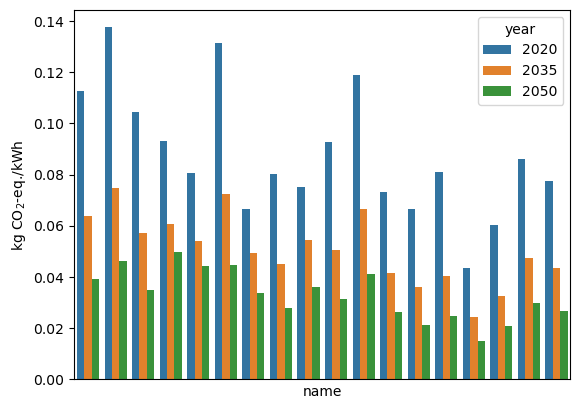

In [15]:
import seaborn as sns

# plot with seaborn barplot
sns.barplot(data=results, x='name', y='GWP', hue='year')

plt.xticks([])
plt.ylabel("kg CO$_2$-eq./kWh")

### 10. Bonus: can you show the respective tranformation contributions?

In [ ]:
db_2050_1 = load_db()
db_2050_1 = modify_module_efficiency(db_2050_1, 2050)

if "PV 2050 - eff" in bw2data.databases:
    del bw2data.databases["PV 2050 - eff"]
    
wurst.write_brightway2_database(db_2050_1, "PV 2050 - eff")

db_2050_2 = load_db()
db_2050_2 = modify_module_efficiency(db_2050_2, 2050)
db_2050_2 = modify_pv_lifetime(db_2050_2, 25, 40)

if "PV 2050 - eff - lifetime" in bw2data.databases:
    del bw2data.databases["PV 2050 - eff - lifetime"]
    
wurst.write_brightway2_database(db_2050_2, "PV 2050 - eff - lifetime")

In [17]:
FU_contributions = [
    {act: 1} for db in [
        "ecoinvent 3.9.1 cutoff", "PV 2050 - eff", "PV 2050 - eff - lifetime", "PV 2050"
    ] for act in bw2data.Database(db) if "electricity production" in act["name"]
    and "photovoltaic" in act["name"] and act["unit"] == "kilowatt hour" 
    and act["location"] == "CH"
]

In [18]:
bw2calc.multi_lca.calculation_setups["PVs - transf contributions"] = {
    "inv": FU_contributions,
    "ia": method
}

In [19]:
lca = bw2calc.MultiLCA("PVs - transf contributions")

/opt/homebrew/Caskroom/miniforge/base/envs/premise_env/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 2.53e+12)
  warnings.warn(msg, UmfpackWarning)


In [20]:
acts = [list(d.keys())[0] for d in lca.func_units]

In [21]:
results = pd.DataFrame(
    zip(
        [a["name"] for a in acts],
        [a["database"] for a in acts],
        lca.results.flatten()
    ),
    columns=["name", "year", "GWP"]
)

In [22]:
results = results.replace("ecoinvent 3.9.1 cutoff", 2020)
results = results.replace("PV 2050 - eff", "2050 -- 1 eff only")
results = results.replace("PV 2050 - eff - lifetime", "2050 -- 2 eff + lifetime ext.")
results = results.replace("PV 2050", "2050 -- 3 eff + lifetime ext. + coal phase out")
results["year"] = results["year"].astype("str")

Text(0, 0.5, 'kg CO$_2$-eq./kWh')

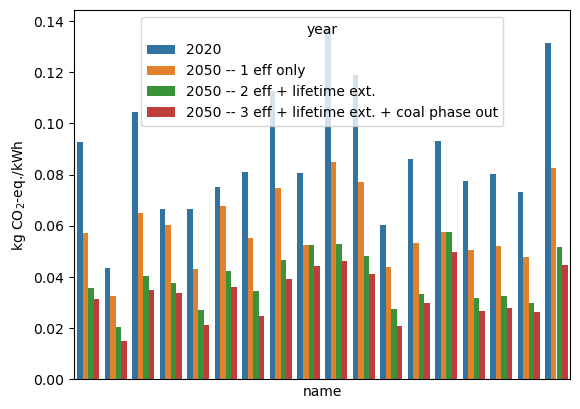

In [23]:
# plot with seaborn barplot
sns.barplot(data=results, x='name', y='GWP', hue='year')
plt.xticks([])
plt.ylabel("kg CO$_2$-eq./kWh")

### 11. Bonus 2: Home storage systems

#### Exercise: Estimating Home Energy Storage Capacity

#### Background:
You want to purchase a solar photovoltaic system for the roof of your residence. 
This system converts sunlight into electricity that powers your home. 
On days when the system produces more electricity than your home consumes, 
the excess energy can be stored in batteries for use during nighttime or on days when the sun isn't shining.

#### Objective:

1. Estimate the solar PV installation and storage capacities required for your home energy storage system, considering only 
the excess solar production that isn't consumed directly by the household during daylight time.
2. Add the storage capacity in photovoltaic electricity production datasets
3. Estimate the increase in carbon footprint resulting from home energy storage.

Given:

1. On average, your location in Switzerland receives 5 hours of effective sunlight per day (i.e., full load).
2. Your household's electricity consumption is 10 kWh during daylight, and 5 kWh during nighttime.
3. You want the storage system to provide enough for the nighttime.
4. Batteries typically have a recommended Depth of Discharge (DoD) of 90%, meaning only 90% of their total capacity should be used to ensure a longer lifespan.
Energy storage systems have a round-trip efficiency of 80%. This accounts for energy losses during the charging and discharging processes. Also,
we assume a 3,000 cycles lifetime for the battery cells (where 1 day = 1 cycle), while the Balance of Plant can outlast the PV installation.
Finally, 30% of the battery system mass is the Balance of Plant.

In [24]:
# Given values for total daily consumption
total_daily_consumption = 15  # kWh (10 kWh daytime + 5 kWh evening)
average_sunlight_hours = 5 # hours

# Calculate the required solar installation capacity for total daily consumption
required_total_solar_capacity = total_daily_consumption / average_sunlight_hours
required_total_solar_capacity # kWp

3.0

In [25]:
# storage capacity
net_storage_capacity = 5 # kWh
net_storage_capacity /= .9 # Depth of Discharge
net_storage_capacity /= .8 # 80% round-trip efficiency

round(net_storage_capacity)

7

In [ ]:
db = load_db()

In [ ]:
import wurst.searching as ws
# let's find battery cell LCIs
for ds in ws.get_many(
    db,
    ws.contains("name", "battery cell, Li-ion")
):
    print(ds["name"])

In [ ]:
cells = ws.get_one(db, ws.contains("name", "market for battery cell, Li-ion, NMC811"))
BoP = ws.get_one(db, ws.contains("name", "battery management system production"))

In [ ]:
# battery sizing
# we assume 1 kg NMC cell = 0.2 kWh storage
# and 30% of the system mass is the Balance of Plant
cell_mass = 7 / 0.2
BoP_mass = .3 * cell_mass / .7

In [ ]:
lifetime_replacements = (25 * 365) / 3000 # 25 years lifetime for the PV, 3000 cycles for the battery

In [ ]:
for ds in ws.get_many(
    db,
    ws.contains("name", "electricity production, photovoltaic"),
    ws.contains("name", "3kWp"),
    ws.equals("location", "CH"),
    ws.equals("unit", "kilowatt hour")
):
    for exc in ws.technosphere(ds, ws.equals("unit", "unit"), ws.contains("name", "photovoltaic")):
        production = 1 / exc["amount"] #kWh/lifetime
    ds["exchanges"].extend(
        [
            {"name": cells["name"], "product": cells["reference product"], "location": cells["location"], "unit": cells["unit"], "amount": cell_mass * lifetime_replacements / production, "type": "technosphere"},
            {"name": BoP["name"], "product": BoP["reference product"], "location": BoP["location"], "unit": BoP["unit"], "amount": BoP_mass / production, "type": "technosphere"},
        ]
        
    )

In [ ]:
if "PV + storage" in bw2data.databases:
    del bw2data.databases["PV + storage"]
wurst.write_brightway2_database(db, "PV + storage")

In [26]:
FU_storage = [
    {act: 1} for db in [
        "ecoinvent 3.9.1 cutoff", "PV + storage", 
    ] for act in bw2data.Database(db) if "electricity production" in act["name"]
    and "photovoltaic" in act["name"] and act["unit"] == "kilowatt hour" 
    and act["location"] == "CH" and "3kWp" in act["name"]
]

In [27]:
bw2calc.multi_lca.calculation_setups["PVs - energy storage"] = {
    "inv": FU_storage,
    "ia": method
}

In [28]:
lca = bw2calc.MultiLCA("PVs - energy storage")
acts = [list(d.keys())[0] for d in lca.func_units]

/opt/homebrew/Caskroom/miniforge/base/envs/premise_env/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.51e+12)
  warnings.warn(msg, UmfpackWarning)


In [29]:
results = pd.DataFrame(
    zip(
        [a["name"] for a in acts],
        [a["database"] for a in acts],
        lca.results.flatten()
    ),
    columns=["name", "storage", "GWP"]
)

In [30]:
results = results.replace("ecoinvent 3.9.1 cutoff", "No storage")
results["year"] = results["storage"].astype("str")

Text(0, 0.5, 'kg CO$_2$-eq./kWh')

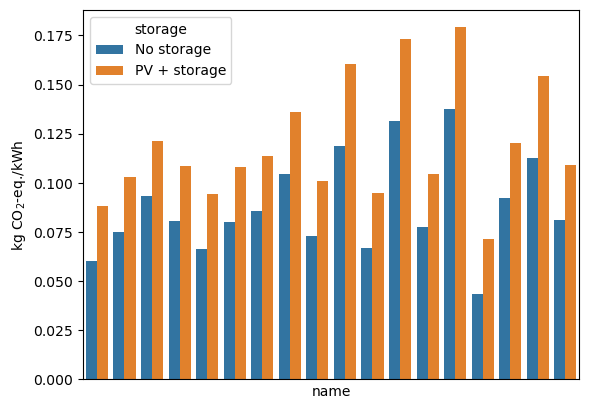

In [31]:
# plot with seaborn barplot
sns.barplot(data=results, x='name', y='GWP', hue='storage')
plt.xticks([])
plt.ylabel("kg CO$_2$-eq./kWh")